# Node Embeddings

## Overview
![](figures/03-nodeemb_2.jpeg) 
![](figures/03-nodeemb_3.jpeg) 
![](figures/03-nodeemb_4.jpeg) 
![](figures/03-nodeemb_5.jpeg) 
![](figures/03-nodeemb_6.jpeg) 

`pytorch_geometric` provides us with some well-known datasets. Here we use `KarateClub` dataset to illustrate how we obtain node embeddings

In [1]:
import networkx as nx
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx
dataset = KarateClub()
G = to_networkx(dataset[0], to_undirected=True)

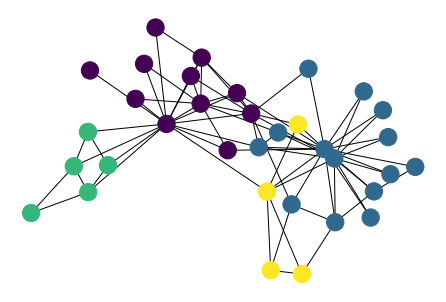

In [2]:
nx.draw(G, node_color=dataset[0].y)

Here we use `Graph Convolutional Network` to build the embeddings.

In [3]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

    
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        # Apply a final (linear) classifier.
        out = self.classifier(h)
        return out, h

In [19]:
data = KarateClub()[0]
model = GCN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

_, h_init = model(data.x, data.edge_index)

def train(data):
    optimizer.zero_grad()
    out, h = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss, h

for epoch in range(50):
    loss, h = train(data)

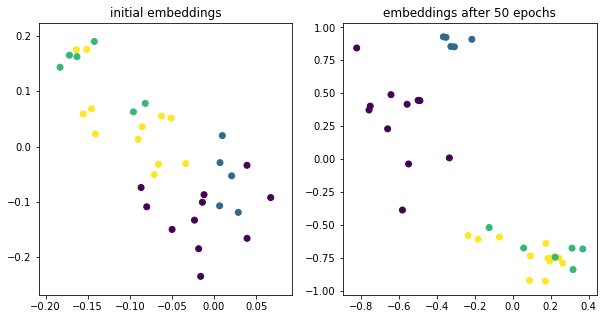

In [23]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

node_embed = h_init.detach().cpu().numpy()
ax[0].scatter(node_embed[:, 0], node_embed[:, 1], c=data.y.numpy())
ax[0].set_title("initial embeddings")

node_embed = h.detach().cpu().numpy()
ax[1].scatter(node_embed[:, 0], node_embed[:, 1], c=data.y.numpy())
ax[1].set_title("embeddings after 50 epochs")
plt.show()